# Customer Lifetime Value using ML approach

Welcome to my implementation tutorial for Customer Lifetime Value!

You are on the first step to better understanding your customers.

Let's begin with our imports and loading in the data.

In [ ]:
# Install libraries
!pip install plydata
!pip install plotnine
!pip install xgboost

In [36]:
# Import libraries
import pandas as pd
import numpy as np
import joblib
import plydata.cat_tools as cat
import plotnine as pn
import matplotlib.pyplot as plt
import math
# Machine Learning
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score,f1_score

## Load and Read the dataset

In [6]:
df_input = pd.read_csv("trans_input_clv_new.csv",engine='python')
df_input.head()

,cust,iri_week,spend
0,1000267102,2022,2.99
1,1000267507,2148,4.49
2,1000270546,2122,4.49
3,1000270546,2148,4.49
4,1000272194,2144,3.99


Some comments about the dataset:
 

1.   We have 3 years of transactions between Apr '18 and Mar '21.
2.   There is a cohort of 50K customers that purchased for first time the first 3 months, Apr '18 to June '18.

Some preliminary counts relevant to the data.

In [7]:
print(f"Number of customers in dataset: {df_input.cust.nunique()}")
print(f"Date range: {df_input.iri_week.min()} - {df_input.iri_week.max()}")

Number of customers in dataset: 50000
Date range: 2013 - 2168


We Frame the problem defining the prediction period. In our example this period will be 6 months aka 26 weeks:


1.   Split the dataset into train and test sample
2.   What will the customers spend the next 6 months, 26 weeks (Regression)
3.   What is a probability of a customer to make a purchase the next 26 weeks (Clasification)

In [8]:
# Split the dataset in train and holdout dataset
def split_data(n_weeks,df_input):
  max_date = df_input['iri_week'].max()
  cutoff = max_date - n_weeks
  temporal_in_df = df_input \
    [df_input['iri_week'] <= cutoff]
  temporal_out_df = df_input \
    [df_input['iri_week'] > cutoff]
  return temporal_in_df,temporal_out_df

# Feature Engineering

Below we implement functions to compute the features we need. We are performing RFM analysis and so we need to compute the Recency, Frequency and Average Monetary Value for each customer.

Keep in mind, we can add additional features too, but they would need to be aggregated across each customer.


## RFM (Recency-Frequency-Monetary Value)

In [9]:
# RFM data structure
def data_preparation(temporal_in_df,temporal_out_df):
  targets_df = temporal_out_df \
    .drop('iri_week', axis=1) \
    .groupby('cust') \
    .sum() \
    .rename({'spend': 'spend_6m'}, axis = 1) \
    .assign(spend_6m_flag = 1)
  max_train_date = temporal_in_df['iri_week'].max()
  recency_features_df = temporal_in_df \
    [['cust', 'iri_week']] \
    .groupby('cust') \
    .apply(
        lambda x: (max_train_date - x['iri_week'].max())) \
    .to_frame() \
    .set_axis(['recency'], axis=1)
  frequency_features_df = temporal_in_df \
    [['cust', 'iri_week']] \
    .groupby('cust') \
    .count() \
    .set_axis(['frequency'], axis=1)
  spend_features_df = temporal_in_df \
    .groupby('cust') \
    .aggregate(
        {
            'spend': ["sum","mean"]
        }
    ) \
    .set_axis(['spend_sum', 'spend_mean'], axis=1)
  # Combine features
  features_df = pd.concat(
      [recency_features_df, frequency_features_df, spend_features_df], axis = 1
      ) \
      .merge(
          targets_df,
          left_index = True,
          right_index = True,
          how = "left"
          ) \
      .fillna(0)
  return features_df

In [10]:
temporal_in_df, temporal_out_df = split_data(26, df_input)
final_df = data_preparation(temporal_in_df,temporal_out_df)

## Concept

The way it works is that we can split the training data into an observed period and a future period. If we want to predict how much a customer will spend in a year, we would set the length of the future period as one year, and the rest would come under observed (as shown below).

![picture](https://drive.google.com/file/d/1xSOVvsr8GyRG2Sf3NW2I7c6oCDh1LGz_/view?usp=share_link)

## Machine Learning Process

XGBoost is a machine learning algorithm that uses an ensemble of decision trees and gradient boosting to make predictions. It is widely used in data science and has won several machine learning competitions.

It is a versatile algorithm that can be used for both classification and regression problems. It can handle different types of data and can be customized for specific needs.

In [11]:
# Regression problem - estimate spend amount the next 6 months
def Regression_Model(final_df):
  X = final_df[['recency', 'frequency', 'spend_sum', 'spend_mean']]
  y_spend = final_df['spend_6m']
  xgb_reg_spec = XGBRegressor(
      objective="reg:squarederror",
      random_state=123
      )
  xgb_reg_model = GridSearchCV(
      estimator=xgb_reg_spec,
      param_grid=dict(
          
          learning_rate = [0.01, 0.1, 0.3, 0.5]
          ),
      scoring = 'neg_mean_absolute_error',
      refit = True,
      cv = 5
      )
  xgb_reg_model.fit(X,y_spend)
  best_score = xgb_reg_model.best_score_
  best_params = xgb_reg_model.best_params_
  best_estimator = xgb_reg_model.best_estimator_
  predictions_reg = xgb_reg_model.predict(X)
  #return best_score,best_params,best_estimator,predictions_reg
  return predictions_reg

In [12]:
# Classification problem - estimate the spend probability the next 6 months
def Classification_Model(final_df):
  X = final_df[['recency', 'frequency', 'spend_sum', 'spend_mean']]
  y_prob = final_df['spend_6m_flag']
  xgb_clf_spec = XGBClassifier(
      
      objective = "binary:logistic",
      random_state = 123
      )
  xgb_clf_model = GridSearchCV(
      
      estimator = xgb_clf_spec,
      param_grid=dict(
          learning_rate = [0.01, 0.1, 0.3, 0.5]
      ),

      scoring = 'roc_auc',
      refit = True,
      cv = 5
      )
  xgb_clf_model.fit(X,y_prob)
  best_score = xgb_clf_model.best_score_
  best_params = xgb_clf_model.best_params_
  best_estimator = xgb_clf_model.best_estimator_
  predictions_clf = xgb_clf_model.predict_proba(X)
  #return best_score,best_params,best_estimator,predictions_clf
  return predictions_clf

In [ ]:
def Validation(final_df):
  predictions_df = pd.concat(
      [
          pd.DataFrame(Regression_Model(final_df)).set_axis(['pred_spend'], axis=1),
          pd.DataFrame(Classification_Model(final_df))[[1]].set_axis(['pred_prob'], axis=1),
          final_df.reset_index()
      ],
      axis=1
      )
  predictions_df['pred_label'] = np.where(predictions_df['pred_prob']>0.5,1,0)
  

In [13]:
# Final dataset with all the predicted values appended
predictions_df = pd.concat(
    [
        pd.DataFrame(Regression_Model(final_df)).set_axis(['pred_spend'], axis=1),
        pd.DataFrame(Classification_Model(final_df))[[1]].set_axis(['pred_prob'], axis=1),
        final_df.reset_index()
    ],
    axis=1
)

In [30]:
predictions_df['pred_label'] = np.where(predictions_df['pred_prob']>0.5,1,0)

In [31]:
predictions_df

,pred_spend,pred_prob,cust,recency,frequency,spend_sum,spend_mean,spend_6m,spend_6m_flag,pred_label
0,2.842700,0.549194,1000246458,20,8,29.73,3.71625,0.00,0.0,1
1,1.006950,0.358428,1000251782,56,4,13.46,3.36500,0.00,0.0,0
2,1.678752,0.360367,1000252771,10,2,12.98,6.49000,0.00,0.0,0
3,1.036742,0.336012,1000257574,42,2,7.98,3.99000,0.00,0.0,0
4,1.384524,0.362181,1000264172,42,3,10.47,3.49000,0.00,0.0,0
...,...,...,...,...,...,...,...,...,...,...
49995,1.248488,0.379711,2998510947,0,2,5.98,2.99000,0.00,0.0,0
49996,1.438342,0.401330,2998510989,50,4,12.96,3.24000,3.49,1.0,0
49997,0.869042,0.315562,2998552060,83,4,10.56,2.64000,0.00,0.0,0
49998,3.015113,0.549194,2998558246,21,8,30.30,3.78750,0.00,0.0,1


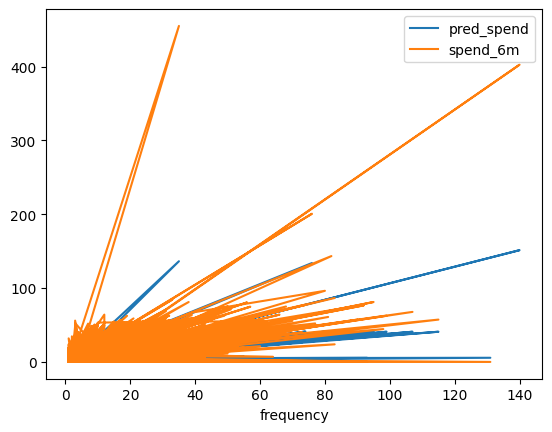

In [20]:
# plot the expected spend vs the actual spend
predictions_df.plot(x='frequency', y=['pred_spend', 'spend_6m'])
plt.show()

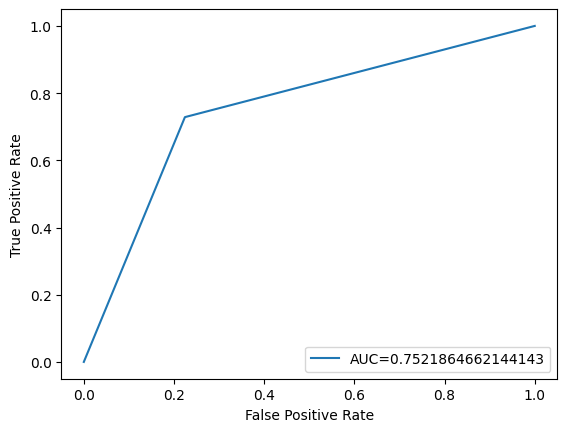

In [32]:
auc = metrics.roc_auc_score(predictions_df['pred_label'],predictions_df['spend_6m_flag'])
fpr, tpr, _ = metrics.roc_curve(predictions_df['pred_label'],predictions_df['spend_6m_flag'])

plt.plot(fpr, tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [37]:
MSE = mean_squared_error(predictions_df['spend_6m'], predictions_df['pred_spend'])
RMSE = math.sqrt(MSE)
print("Mean_Squared_Error:\n")
print(MSE)
print(RMSE)

Mean_Squared_Error:

31.255097122117608
5.590625825622531
